In [2]:
!pip install -qU langsmith==0.1.125 \
  langchain-core==0.2.41 \
  langchain-community \
  langchain-qdrant==0.1.4 \
  langchain-experimental \
  langchain-openai \
  langchain_huggingface \
  PyMuPDF==1.24.10 \
  ragas==0.1.18 \
  protobuf==3.20.3 \
  pyarrow==14.0.1 \
  fsspec==2024.6.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1

In [3]:
import os
import getpass
from uuid import uuid4
from google.colab import userdata


os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

os.environ["LANGCHAIN_PROJECT"] = "AIM-SDG-MidTerm - AI Safety"
# os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

# os.environ["QDRANT_API_KEY"] = getpass.getpass("Enter Your Qdrant API Key: ")
os.environ["QDRANT_API_KEY"] = userdata.get('QDRANT_API_KEY')

os.environ["QDRANT_URL"] = userdata.get('QDRANT_URL')


# Synthetic data generation using Ragas framework

We will generate set of synthetic data for evaluating different opetions
1. Evaluating Embedding model
2. Evaluating Chunking Strategies

In [4]:
from langchain_experimental.text_splitter import SemanticChunker

from enum import Enum
from typing import List
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.documents import Document
import asyncio

class PDFLoaderWrapper():
    class LoaderType(str, Enum):
        PYMUPDF = "pymupdf"

    def __init__(self, file_path: str | List[str] , loader_type: LoaderType = LoaderType.PYMUPDF):
        self.file_path = file_path if isinstance(file_path, list) else [file_path]
        self.loader_type = loader_type

    async def aload(self) -> List[Document]:
        all_docs = []
        for file_path in self.file_path:
            if self.loader_type == self.LoaderType.PYMUPDF:
                try:
                    loader = PyMuPDFLoader(file_path)
                    docs = await loader.aload()
                    all_docs.extend(docs)
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")
                    continue
        return all_docs

BOR_FILE_PATH = "https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-of-Rights.pdf"
NIST_FILE_PATH = "https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf"
documents = [
    BOR_FILE_PATH,
    NIST_FILE_PATH
]

pdf_loader = PDFLoaderWrapper(
    documents, PDFLoaderWrapper.LoaderType.PYMUPDF
)
documents = await pdf_loader.aload()



In [5]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from ragas.testset.docstore import Document, DocumentStore,InMemoryDocumentStore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from ragas.testset.extractor import KeyphraseExtractor

print ("Packages import complete")
print ("Getting the Embedding model from Huggingface")
# Using best performing embedding model from hugging face to generate quality dataset.
# # Need GPU
# model_name = "Snowflake/snowflake-arctic-embed-l"
# embedding_model = HuggingFaceEmbeddings(model_name=model_name)

model = "text-embedding-3-large"
dimension = 3072
embedding_model = OpenAIEmbeddings(model=model,dimensions=dimension)
print ("Embedding model loaded")

print ("Splitting the documents into semantic chunks")
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024,
    chunk_overlap = 100,
    length_function = len,
)
chunked_docs = text_splitter.split_documents(documents)

print ("Creating the document store for ragas and loading LLM models")
generator_llm = ChatOpenAI(model="gpt-4o")
critic_llm = ChatOpenAI(model="gpt-4o")

# keyphrase_extractor = KeyphraseExtractor(llm=generator_llm)
# docstore = InMemoryDocumentStore(splitter=text_splitter,extractor=keyphrase_extractor, embeddings=embedding_model)

print ("Creating the testset generator")
generator = TestsetGenerator.from_langchain( # Default uses TokenTextSplitter
    generator_llm=generator_llm,
    critic_llm=critic_llm,
    embeddings=embedding_model,
    #docstore=docstore # Document store uses SemenaticChunker
)

distributions = {
    simple: 0.5,
    multi_context: 0.3,
    reasoning: 0.2
}

Packages import complete
Getting the Embedding model from Huggingface
Embedding model loaded
Splitting the documents into semantic chunks
Creating the document store for ragas and loading LLM models
Creating the testset generator


In [6]:
test_size = 50

testset = generator.generate_with_langchain_docs(
    documents,
    test_size,
    distributions,
    with_debugging_logs=True
) # Default  RunConfig(max_retries=15, max_wait=90)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
testset_df = testset.to_pandas()
testset_df

question  \
0   What techniques are suggested to assess and ma...   
1   What actions are suggested to ensure informati...   
2   What are the requirements for providing access...   
3   What issues arose from the system awarding ben...   
4   How is the federal government working to comba...   
5   What are the characteristics of trustworthy AI...   
6   What are the conditions under which individual...   
7   What is data poisoning and how can it affect G...   
8   How do opaque decision-making processes in aut...   
9   Who participated in the OSTP meetings focused ...   
10  What actions are suggested for explaining and ...   
11  What provisions are included in the Biometric ...   
12  How should designers, developers, and deployer...   
13  How do systems related to the assignment of pe...   
14  What should be the focus of risk identificatio...   
15  What procedures should be established and main...   
16  How do GAI systems contribute to the creation ...   
17  How can synthetic content detection help manag...   
18  What organizational practices are in place to ...   
19  What techniques are suggested to minimize risk...   
20  Who were some of the participants from the pri...   
21  What role does the National Institute of Stand...   
22  What should entities responsible for the devel...   
23  How has the customer service industry successf...   
24  What steps should be taken to inform AI stakeh...   
25  How do the U.S. AI Safety Institute and AI Ris...   
26  How to balance synthetic vs. non-synthetic dat...   
27  How to address data privacy and ensure AI inte...   
28  How can public feedback and incident reporting...   
29  How could automation bias worsen misinformatio...   
30  How do consultations and monitoring ensure aut...   
31  How do EO 13960 and NIST AI RMF ensure AI tran...   
32  How does surveillance software for monitoring ...   
33  How can provenance tracking and public feedbac...   
34  How can designers ensure user understanding an...   
35  How do equity and disparity assessments help p...   
36  How do school audio surveillance systems for s...   
37  How does the tech companion help implement AI ...   
38  How to mitigate Human-AI risks in evaluations ...   
39  How to design explanatory mechanisms in high-r...   
40  How do biometrics affect access and decisions ...   
41  How do equity assessments and disparity tests ...   
42  How does synthetic data proportion help preven...   
43  How do hiring algorithms and social media data...   
44  How can unproven tech and data misuse cause harm?   
45  Why compare system performance with human meth...   
46             How do confident errors mislead users?   
47  How do data biases impact loans, hiring, and e...   
48  How to design systems to avoid algorithmic bia...   

                                             contexts  \
0   [ \n30 \nMEASURE 2.2: Evaluations involving hu...   
1   [ \n28 \nMAP 5.2: Practices and personnel for ...   
2   [ \n \n \n \n \n \nHUMAN ALTERNATIVES, \nCONSI...   
3   [ \n \n  \n \n \nNOTICE & \nEXPLANATION \nWHY ...   
4   [ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n...   
5   [ \n14 \nGOVERN 1.2: The characteristics of tr...   
6   [ \nSECTION TITLE\nHUMAN ALTERNATIVES, CONSIDE...   
7   [ \n11 \nvalue chain (e.g., data inputs, proce...   
8   [ \n \n  \n \n \nNOTICE & \nEXPLANATION \nWHY ...   
9   [APPENDIX\n• OSTP conducted meetings with a va...   
10  [ \n35 \nMEASURE 2.9: The AI model is explaine...   
11  [ \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n...   
12  [ \n \n \n \n \nSECTION TITLE\nDATA PRIVACY\nY...   
13  [APPENDIX\nSystems that impact the safety of c...   
14  [ \n \n \n \n \n \n \nSAFE AND EFFECTIVE \nSYS...   
15  [ \n42 \nMG-2.4-002 \nEstablish and maintain p...   
16  [ \n10 \nGAI systems can ease the unintentiona...   
17  [ \n51 \ngeneral public participants. For exam...   
18  [ \n19 \nGV-4.1-003 \nEstablish policies, proc...   
19  [ \n30 \nMEASURE 2.2: Evaluations involving hu... 

In [8]:
testset_df.to_csv('task5-ai-safety-sdg3.csv', index=False)
test_questions = testset_df["question"].values.tolist()
test_groundtruths = testset_df["ground_truth"].values.tolist()

## Create Rag chain to generate answers for above questions in the dataset

> Note that we are usig Qdrant cloud where the pdf document is processed and saved for us to consume. For the RAG pipeline we use the same embedding model originally used to populate the Qdrant vectorstore.

In [9]:
len(chunked_docs)

466

In [10]:
from langchain_qdrant import QdrantVectorStore
from langchain_core.documents import Document
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

chunked_docs
model = "text-embedding-3-large"
dimension = 3072
embeddings = OpenAIEmbeddings(model=model,dimensions=dimension)

qdrant_client = QdrantClient(location=":memory:")
qdrant_client.create_collection(
    collection_name='sdg-answers',
    vectors_config=VectorParams(size=dimension, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name='sdg-answers',
    embedding=embeddings,
)

retriever = vector_store.as_retriever(search_kwargs={'k':10})

In [11]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [12]:
from langchain_openai import ChatOpenAI

# Using the same model used in the app.
chat_model_name = "gpt-4o"
llm = ChatOpenAI(model=chat_model_name)

In [13]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain_generate_anwsers = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [14]:
rag_chain_generate_anwsers.invoke({"question" : "What procedures should be established and maintained for escalating GAI system incidents to the organizational risk management authority?"})

"I don't know."

# Create Rag Chain with config

We are going to replicate the exact implementation used in the hosted RAG app but with different configuration to evaluate and compare.

In [15]:
# Utility function to create a rag chain with config
from langchain_experimental.text_splitter import SemanticChunker
from enum import Enum
from typing import List
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.documents import Document
import asyncio
from langchain_qdrant import QdrantVectorStore
from langchain_core.documents import Document
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.prompts import MessagesPlaceholder
from langchain.prompts import ChatPromptTemplate
from langchain.chains.history_aware_retriever import create_history_aware_retriever
from langchain.chains.retrieval import create_retrieval_chain
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory

BOR_FILE_PATH = "https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-of-Rights.pdf"
NIST_FILE_PATH = "https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf"
documents_to_preload = [
    BOR_FILE_PATH,
    NIST_FILE_PATH
]
store = {}

class PDFLoaderWrapper():
    class LoaderType(str, Enum):
        PYMUPDF = "pymupdf"

    def __init__(self, file_path: str | List[str] , loader_type: LoaderType = LoaderType.PYMUPDF):
        self.file_path = file_path if isinstance(file_path, list) else [file_path]
        self.loader_type = loader_type

    async def aload(self) -> List[Document]:
        all_docs = []
        for file_path in self.file_path:
            if self.loader_type == self.LoaderType.PYMUPDF:
                try:
                    loader = PyMuPDFLoader(file_path)
                    docs = await loader.aload()
                    all_docs.extend(docs)
                except Exception as e:
                    print(f"Error loading file {file_path}: {e}")
                    continue
        return all_docs

async def get_contextual_compressed_retriever(retriver):

    compressor_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=1500)
    compressor = LLMChainExtractor.from_llm(compressor_llm)

    #Combine the retriever with the compressor
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=retriver
    )
    return compression_retriever

def create_history_aware_retriever_self(chat_model, retriever):
    contextualize_q_system_prompt = (
        "Given a chat history and the latest user question which might reference context in the chat history, "
        "formulate a standalone question which can be understood without the chat history. Do NOT answer the question, "
        "just reformulate it if needed and otherwise return it as is."
    )
    contextualize_q_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", contextualize_q_system_prompt),
            MessagesPlaceholder("chat_history"),
            ("human", "{input}"),
        ]
    )
    return create_history_aware_retriever(chat_model, retriever, contextualize_q_prompt)

def create_qa_chain(chat_model):
    qa_system_prompt = (
        "You are an helpful assistant named 'Shield' and your task is to answer any questions related to AI Safety for the given context."
        "Use the following pieces of retrieved context to answer the question."
        # "If any questions asked outside AI Safety context, just say that you are a specialist in AI Safety and can't answer that."
        # f"When introducing you, just say that you are an AI assistant powered by embedding model {embedding_model_name} and chat model {chat_model_name} and your knowledge is limited to 'Blueprint for an AI Bill of Rights' and 'NIST AI Standards' documents."
        "If you don't know the answer, just say that you don't know.\n\n"
        "{context}"
    )
    qa_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", qa_system_prompt),
            MessagesPlaceholder("chat_history"),
            ("human", "{input}"),
        ]
    )
    return create_stuff_documents_chain(chat_model, qa_prompt)

def create_conversational_rag_chain(chat_model, retriever):
    history_aware_retriever = create_history_aware_retriever_self(chat_model, retriever)
    question_answer_chain = create_qa_chain(chat_model)
    return create_retrieval_chain(history_aware_retriever, question_answer_chain)

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


pdf_loader = PDFLoaderWrapper(
    documents_to_preload, PDFLoaderWrapper.LoaderType.PYMUPDF
)
documents = await pdf_loader.aload()

async def get_contextual_compressed_retriever(retriver):

    base_retriever = retriver
    compressor_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=4000)
    compressor = LLMChainExtractor.from_llm(compressor_llm)

    #Combine the retriever with the compressor
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=base_retriever
    )
    return compression_retriever

async def create_rag_chain(huggingface_embedding,text_splitter,collection_name,):

    chunked_docs = text_splitter.split_documents(documents)
    dimension = 1024
    qdrant_client = QdrantClient(location=":memory:")

    # Below fails if collection already exists so make sure to delete the collection first
    qdrant_client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=dimension, distance=Distance.COSINE),
    )

    vector_store = QdrantVectorStore(
        client=qdrant_client,
        collection_name=collection_name,
        embedding=huggingface_embedding,
    )
    vector_store.add_documents(chunked_docs)

    retriever = vector_store.as_retriever(search_kwargs={'k':10})

     # Using the same model used in the app.
    chat_model_name = "gpt-4o"
    llm = ChatOpenAI(model=chat_model_name,temperature=0)
    RAG_PROMPT = """\
    Given a provided context and question, you must answer the question based only on context.

    If you cannot answer the question based on the context - you must say "I don't know".

    Context: {context}
    Question: {question}
    """

    rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)
    ai_safety_rag_chain = (
      {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
      | RunnablePassthrough.assign(context=itemgetter("context"))
      | {"response": rag_prompt | llm | StrOutputParser(), "context": itemgetter("context")}
    )
    return ai_safety_rag_chain, retriever



# RAGAS Evaluation for Embedding Model

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load the embedding models
base_embedding_model = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
fine_tuned_embedding_model = HuggingFaceEmbeddings(model_name="jeevanions/finetuned_arctic-embedd-l")

# Common splitter to keep variables minimum
recursive_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024,
    chunk_overlap = 100,
    length_function = len,
)
recursive_chunked_docs = recursive_text_splitter.split_documents(documents)

# Create two rag chaings with different embeddings
rag_chain_base, retriever_base = await create_rag_chain(
    base_embedding_model,
    recursive_text_splitter,
    "snowflake-arctic-embed-l-recursive-base"
)

rag_chain_fine_tuned, retriever_fine_tuned = await create_rag_chain(
    fine_tuned_embedding_model,
    recursive_text_splitter,
    "snowflake-arctic-embed-l-recursive-ft"
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/84.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/277 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [26]:
# Adding utility function to run evaluation
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]


def ragas_evaluate(chain):
  answers = []
  contexts = []

  for question in test_questions:
    response = chain.invoke({"question" : question})
    answers.append(response["response"])
    contexts.append([context.page_content for context in response["context"]])

  response_dataset = Dataset.from_dict({
      "question" : test_questions,
      "answer" : answers,
      "contexts" : contexts,
      "ground_truth" : test_groundtruths
  })

  eval_results = evaluate(response_dataset, metrics)

  eval_results_df = eval_results.to_pandas()
  return eval_results_df

In [17]:
# First Base model chain
base_chain_eval_results_df = ragas_evaluate(rag_chain_base)

Evaluating:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


question  \
0   What techniques are suggested to assess and ma...   
1   What actions are suggested to ensure informati...   
2   What are the requirements for providing access...   
3   What issues arose from the system awarding ben...   
4   How is the federal government working to comba...   
5   What are the characteristics of trustworthy AI...   
6   What are the conditions under which individual...   
7   What is data poisoning and how can it affect G...   
8   How do opaque decision-making processes in aut...   
9   Who participated in the OSTP meetings focused ...   
10  What actions are suggested for explaining and ...   
11  What provisions are included in the Biometric ...   
12  How should designers, developers, and deployer...   
13  How do systems related to the assignment of pe...   
14  What should be the focus of risk identificatio...   
15  What procedures should be established and main...   
16  How do GAI systems contribute to the creation ...   
17  How can synthetic content detection help manag...   
18  What organizational practices are in place to ...   
19  What techniques are suggested to minimize risk...   
20  Who were some of the participants from the pri...   
21  What role does the National Institute of Stand...   
22  What should entities responsible for the devel...   
23  How has the customer service industry successf...   
24  What steps should be taken to inform AI stakeh...   
25  How do the U.S. AI Safety Institute and AI Ris...   
26  How to balance synthetic vs. non-synthetic dat...   
27  How to address data privacy and ensure AI inte...   
28  How can public feedback and incident reporting...   
29  How could automation bias worsen misinformatio...   
30  How do consultations and monitoring ensure aut...   
31  How do EO 13960 and NIST AI RMF ensure AI tran...   
32  How does surveillance software for monitoring ...   
33  How can provenance tracking and public feedbac...   
34  How can designers ensure user understanding an...   
35  How do equity and disparity assessments help p...   
36  How do school audio surveillance systems for s...   
37  How does the tech companion help implement AI ...   
38  How to mitigate Human-AI risks in evaluations ...   
39  How to design explanatory mechanisms in high-r...   
40  How do biometrics affect access and decisions ...   
41  How do equity assessments and disparity tests ...   
42  How does synthetic data proportion help preven...   
43  How do hiring algorithms and social media data...   
44  How can unproven tech and data misuse cause harm?   
45  Why compare system performance with human meth...   
46             How do confident errors mislead users?   
47  How do data biases impact loans, hiring, and e...   
48  How to design systems to avoid algorithmic bia...   

                                             contexts  \
0   [• Accessibility and reasonable \naccommodatio...   
1   [Priorities Related to Information Integrity R...   
2   [detailed steps toward actualizing these princ...   
3   [results, and actions taken; and the procedure...   
4   [for any resulting algorithmic discrimination....   
5   [organization’s business processes or other ac...   
6   [detailed steps toward actualizing these princ...   
7   [Information Integrity; Information \nSecurity...   
8   [for any resulting algorithmic discrimination....   
9   [BLUEPRINT FOR AN \nAI BILL OF \nRIGHTS \nMAKI...   
10  [lifecycle and informed by representative AI A...   
11  [for any resulting algorithmic discrimination....   
12  [detailed steps toward actualizing these princ...   
13  [for any resulting algorithmic discrimination....   
14  [detailed steps toward actualizing these princ...   
15  [Table of Contents \n1. \nIntroduction ..........   
16  [and a human who is interacting with it. Human...   
17  [Information Integrity; Information \nSecurity...   
18  [• Accessibility and reasonable \naccommodatio...   
19  [external use, narrow vs. broad application sc... 

In [18]:
base_chain_eval_results_df.to_csv('base_chain_eval_results_df.csv', index=False)

In [20]:
# For Fine Tuned model chain
ft_chain_eval_results_df = ragas_evaluate(rag_chain_fine_tuned)

Evaluating:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [21]:
ft_chain_eval_results_df.to_csv('ft_chain_eval_results_df.csv', index=False)

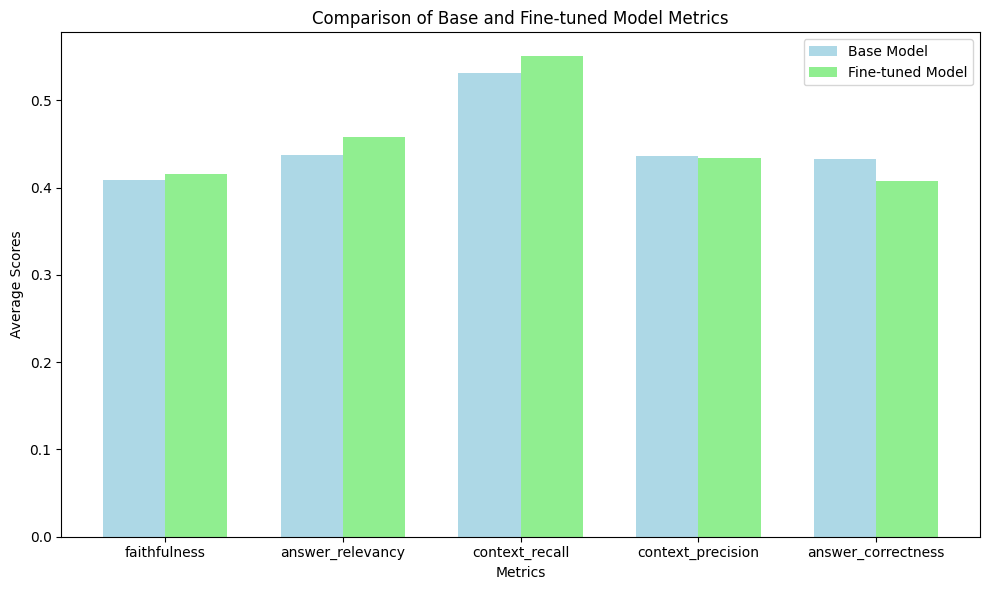

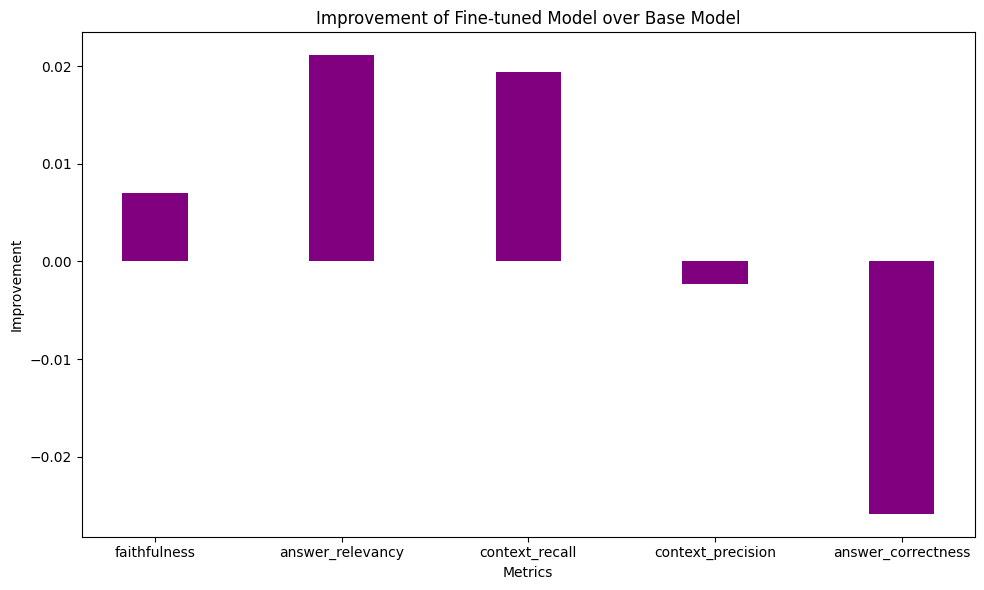

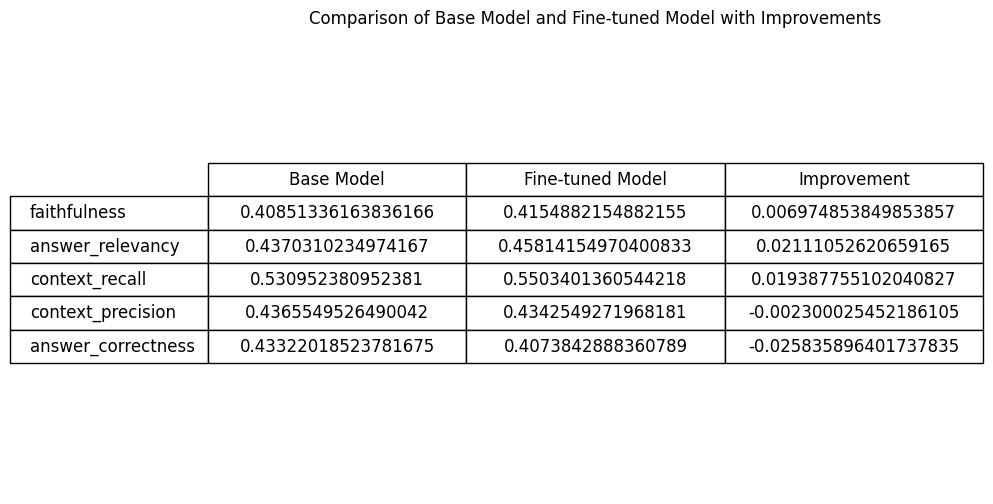

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'answer_correctness']

# Calculate the average scores for each metric in both base and fine-tuned models
base_avg = base_chain_eval_results_df[metrics].mean()
ft_avg = ft_chain_eval_results_df[metrics].mean()

# Calculate improvement (fine-tuned - base)
improvement = ft_avg - base_avg

# Create a summary dataframe
summary_df = pd.DataFrame({
    'Base Model': base_avg,
    'Fine-tuned Model': ft_avg,
    'Improvement': improvement
})

# ------------------ Plotting the Bar Graph ------------------
# Labels for metrics
labels = metrics

# Set width for bars
bar_width = 0.35

# Set positions for the bars
index = np.arange(len(labels))

# Create the figure and the subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for the base model and fine-tuned model
bar1 = ax.bar(index, base_avg, bar_width, label='Base Model', color='lightblue')
bar2 = ax.bar(index + bar_width, ft_avg, bar_width, label='Fine-tuned Model', color='lightgreen')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Average Scores')
ax.set_title('Comparison of Base and Fine-tuned Model Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

# ------------------ Plotting the Improvement Graph ------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Plot improvement as a bar chart
improvement_bar = ax.bar(index, improvement, bar_width, color='purple')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Improvement')
ax.set_title('Improvement of Fine-tuned Model over Base Model')
ax.set_xticks(index)
ax.set_xticklabels(labels)

# Display the plot
plt.tight_layout()
plt.show()

# ------------------ Creating a Table ------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table from summary_df
table = ax.table(cellText=summary_df.values,
                 colLabels=summary_df.columns,
                 rowLabels=summary_df.index,
                 cellLoc='center',
                 loc='center')

# Adjust table scale
table.scale(1, 2)

# Set font size
table.set_fontsize(12)

plt.title('Comparison of Base Model and Fine-tuned Model with Improvements')

# Show the table
plt.show()


# RAGAS Evaluation for chunking strategy

In [24]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker

# Using fine_tuned_embedding_model from before

# First Semantic chunker

semantic_chunker = SemanticChunker(
            embedding_model,
            buffer_size=3,
            breakpoint_threshold_type="percentile",
            breakpoint_threshold_amount=90,
        )

# second Splitter RecursiveCharacterTextSplitter
recursive_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024,
    chunk_overlap = 100,
    length_function = len,
)
recursive_chunked_docs = recursive_text_splitter.split_documents(documents)

#### Create two rag chains with different chunking strategy
# Semantic chunker
rag_chain_semantic,retriever_semantic  = await create_rag_chain(
    fine_tuned_embedding_model,
    semantic_chunker,
    "snowflake-arctic-embed-l-ft"
)

# Recursive splitter
rag_chain_recursive, retriever_recursive = await create_rag_chain(
    fine_tuned_embedding_model,
    recursive_text_splitter,
    "snowflake-arctic-embed-l-ft"
)



In [27]:
# Run evaluation for the semantic chunker based rag chain
semantic_df = ragas_evaluate(rag_chain_semantic)

Evaluating:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [30]:
# Run evaluation for the Recursive splitter based rag chain
recursive_df = ragas_evaluate(rag_chain_recursive)

Evaluating:   0%|          | 0/245 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by mode='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [28]:
semantic_df.to_csv('semantic_df', index=False)

In [31]:
recursive_df.to_csv('recursive_df', index=False)

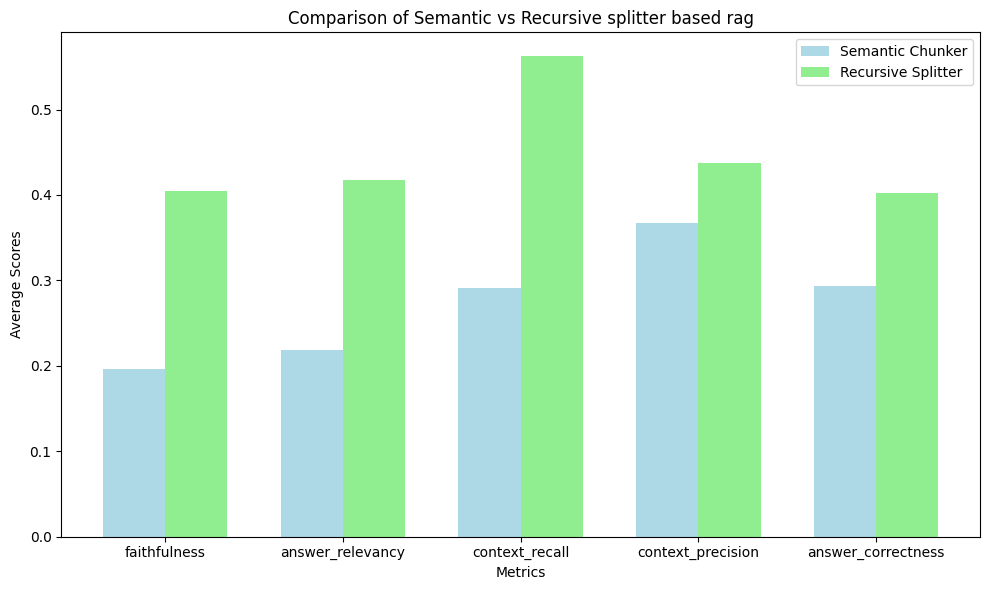

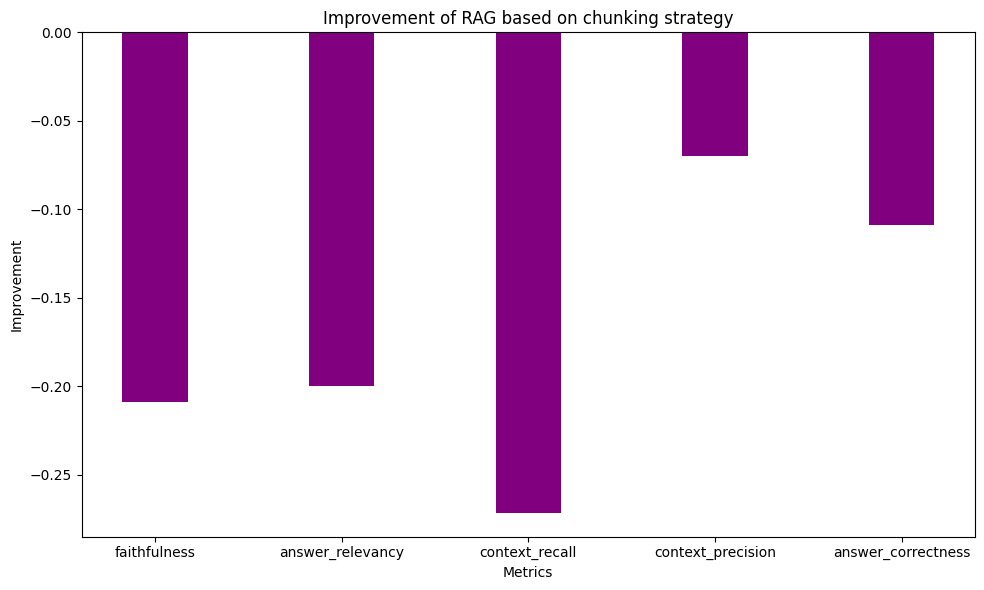

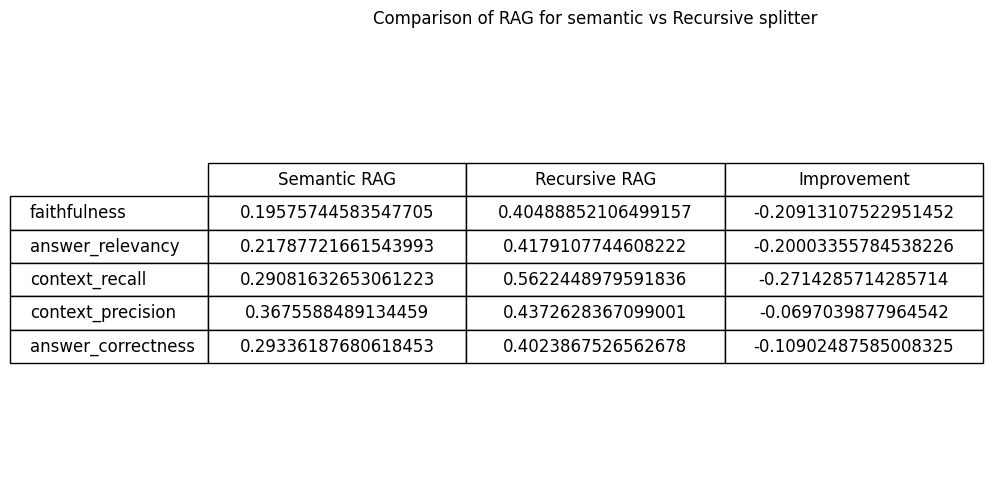

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision', 'answer_correctness']

# Calculate the average scores for each metric in both semantic and recursive rag
semantic_avg = semantic_df[metrics].mean()
recursive_avg = recursive_df[metrics].mean()

# Calculate improvement (semantic and recursive)
improvement = semantic_avg - recursive_avg

# Create a summary dataframe
summary_df = pd.DataFrame({
    'Semantic RAG': semantic_avg,
    'Recursive RAG': recursive_avg,
    'Improvement': improvement
})

# ------------------ Plotting the Bar Graph ------------------
# Labels for metrics
labels = metrics

# Set width for bars
bar_width = 0.35

# Set positions for the bars
index = np.arange(len(labels))

# Create the figure and the subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for the semantic and recursive splitter
bar1 = ax.bar(index, semantic_avg, bar_width, label='Semantic Chunker', color='lightblue')
bar2 = ax.bar(index + bar_width, recursive_avg, bar_width, label='Recursive Splitter', color='lightgreen')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Average Scores')
ax.set_title('Comparison of Semantic vs Recursive splitter based rag')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

# ------------------ Plotting the Improvement Graph ------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Plot improvement as a bar chart
improvement_bar = ax.bar(index, improvement, bar_width, color='purple')

# Adding labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Improvement')
ax.set_title('Improvement of RAG based on chunking strategy')
ax.set_xticks(index)
ax.set_xticklabels(labels)

# Display the plot
plt.tight_layout()
plt.show()

# ------------------ Creating a Table ------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table from summary_df
table = ax.table(cellText=summary_df.values,
                 colLabels=summary_df.columns,
                 rowLabels=summary_df.index,
                 cellLoc='center',
                 loc='center')

# Adjust table scale
table.scale(1, 2)

# Set font size
table.set_fontsize(12)

plt.title('Comparison of RAG for semantic vs Recursive splitter')

# Show the table
plt.show()


In [72]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
